# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV



import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\SABEENA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\SABEENA\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
#Sampling 100K points 
final=final.groupby('Score').apply(lambda x: x.sample(50000))#sampling equal number of points from each class
final['Score'].value_counts()

1    50000
0    50000
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My husband and I visit the Florida Keys quite often. We always make sure that we treat ourselves to some wonderful Key Lime Pie. In the past we have always brought home fresh Key lime fruit from some market in Key West. Due to flight regulations and restrictions, we were unable to bring it home this past December. So I decided to purchase some online and this is how we found this brand and used it. It was a real disappointment.The juice tasted like any ordinary lemon juice and lacked that floral bitter tang that Key Limes are famous for.I don't know how this brand can call themselves the famous and original.The juice is from concentrate and who knows what kind of process it went through but it definitely lacked freshness and I will never buy it again.
Maybe I'm just spoiled by a lifetime of "red-flavored" artificial cherry fruit snacks, but ... these tasted like raisins.  Basically indistinguishable from raisins.
GoSicknic!<br /><br />Just because I can't eat gluten, doesn't mean I wan

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My husband and I visit the Florida Keys quite often. We always make sure that we treat ourselves to some wonderful Key Lime Pie. In the past we have always brought home fresh Key lime fruit from some market in Key West. Due to flight regulations and restrictions, we were unable to bring it home this past December. So I decided to purchase some online and this is how we found this brand and used it. It was a real disappointment.The juice tasted like any ordinary lemon juice and lacked that floral bitter tang that Key Limes are famous for.I don't know how this brand can call themselves the famous and original.The juice is from concentrate and who knows what kind of process it went through but it definitely lacked freshness and I will never buy it again.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My husband and I visit the Florida Keys quite often. We always make sure that we treat ourselves to some wonderful Key Lime Pie. In the past we have always brought home fresh Key lime fruit from some market in Key West. Due to flight regulations and restrictions, we were unable to bring it home this past December. So I decided to purchase some online and this is how we found this brand and used it. It was a real disappointment.The juice tasted like any ordinary lemon juice and lacked that floral bitter tang that Key Limes are famous for.I don't know how this brand can call themselves the famous and original.The juice is from concentrate and who knows what kind of process it went through but it definitely lacked freshness and I will never buy it again.
Maybe I'm just spoiled by a lifetime of "red-flavored" artificial cherry fruit snacks, but ... these tasted like raisins.  Basically indistinguishable from raisins.
GoSicknic!Just because I can't eat gluten, doesn't mean I want to eat gar

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

GoSicknic!<br /><br />Just because I can not eat gluten, does not mean I want to eat garbage. This "meal" (and I use the term loosely) is nothing but processed, sodium-ridden, chemically-laden junk in a box! I have to hand it to the marketers who created this line -- they have been so slick, this line of food trash has infiltrated the health food sections of grocery stores everywhere.<br /><br />Besides being somewhat bizarre in components, this "meal" is packed with highly-allergenic items such as cheese spread, a piece of nut candy, sulfur dioxide, sodium nitrites, BHA and BHT! I mean, the gluten-free crackers are a real head-scratcher ... might as well have put Ritz in there.<br /><br />Obviously whoever put this trippy repast together is not familiar with food allergies. I suspect the crackers are a red herring to put the shopper off the trail of the anaphylactic shock value of the rest of the box. It should come with a free albuterol inhaler and an Epipen. Maybe the Epipen could h

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My husband and I visit the Florida Keys quite often. We always make sure that we treat ourselves to some wonderful Key Lime Pie. In the past we have always brought home fresh Key lime fruit from some market in Key West. Due to flight regulations and restrictions, we were unable to bring it home this past December. So I decided to purchase some online and this is how we found this brand and used it. It was a real disappointment.The juice tasted like any ordinary lemon juice and lacked that floral bitter tang that Key Limes are famous for.I don't know how this brand can call themselves the famous and original.The juice is from concentrate and who knows what kind of process it went through but it definitely lacked freshness and I will never buy it again.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

GoSicknic br br Just because I can not eat gluten does not mean I want to eat garbage This meal and I use the term loosely is nothing but processed sodium ridden chemically laden junk in a box I have to hand it to the marketers who created this line they have been so slick this line of food trash has infiltrated the health food sections of grocery stores everywhere br br Besides being somewhat bizarre in components this meal is packed with highly allergenic items such as cheese spread a piece of nut candy sulfur dioxide sodium nitrites BHA and BHT I mean the gluten free crackers are a real head scratcher might as well have put Ritz in there br br Obviously whoever put this trippy repast together is not familiar with food allergies I suspect the crackers are a red herring to put the shopper off the trail of the anaphylactic shock value of the rest of the box It should come with a free albuterol inhaler and an Epipen Maybe the Epipen could have cartoon characters on it to appeal more to 

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 100000/100000 [01:00<00:00, 1662.38it/s]


In [24]:
preprocessed_reviews[1500]

'gosicknic not eat gluten not mean want eat garbage meal use term loosely nothing processed sodium ridden chemically laden junk box hand marketers created line slick line food trash infiltrated health food sections grocery stores everywhere besides somewhat bizarre components meal packed highly allergenic items cheese spread piece nut candy sulfur dioxide sodium nitrites bha bht mean gluten free crackers real head scratcher might well put ritz obviously whoever put trippy repast together not familiar food allergies suspect crackers red herring put shopper trail anaphylactic shock value rest box come free albuterol inhaler epipen maybe epipen could cartoon characters appeal kids frankly whole line meals haphazard feel harried not bright mother hastily throwing bunch randomly chosen non perishable food items box kid late school bus forgot go grocery store please would better eating cardboard meal came implore read nutritional information side box well actual ingredients put stuff body br

In [25]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=preprocessed_reviews

In [26]:
#Storing processed reviews and corresponding Scores separately
X = np.array(final['CleanedText'])
Y = np.array(final['Score']) 


In [27]:
#Train Test Splitcross_validation.train_test_split
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split (X, Y, test_size=0.3, random_state=0)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [28]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████| 100000/100000 [00:36<00:00, 2726.68it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW 
count_vect = CountVectorizer() #in scikit-learn
final_counts=count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])

Xtrain_bow = count_vect.transform(X_train)
Xtest_bow=count_vect.transform(X_test)



some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhh', 'aaaaaahhhhhyaaaaaa']


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_counts=count_vect.fit(X_train)

Xtrain_bbw = final_counts.transform(X_train)
Xtest_bbw = final_counts.transform(X_test)



## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_counts=tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

Xtrain_tf = final_counts.transform(X_train)
Xtest_tf=final_counts.transform(X_test)


some sample features(unique words in the corpus) ['aa', 'aafco', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'ability', 'able', 'able buy']


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 4: Apply Naive Bayes

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [32]:
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from math import log10

In [39]:
#Using k-fold cross validation
cv_scores=[]
alph=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,100,1000,10000] 

for i in alph:
    clf=MultinomialNB(alpha=i)
    scores = cross_val_score(clf,Xtrain_bbw, Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
MAUC = [ x for x in cv_scores]    
optimal_al = alph[MAUC.index(max(MAUC))]
print('\nThe optimal alpha is %f.' % optimal_al)



The optimal alpha is 0.100000.


In [44]:
#Using GridSearchCV

tuned_parameters = [{'alpha':[10**-5,10**-4,10**-3,10**-2,10**-1,10,10**2,10**3,10**4]}]
model = GridSearchCV(MultinomialNB(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_bbw, Y_train)

print(model.best_estimator_)
print(model.score(Xtest_bbw, Y_test))

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
0.9378824649097419


In [36]:
#Feature Importance
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
clf_optimal=MultinomialNB(.01)
clf_optimal.fit(Xtrain_bbw,Y_train)

neg_class_prob_sorted = clf_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf_optimal.feature_log_prob_[1, :].argsort()
    

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [49]:
print("\nImportant words in predicting positive class:")
print("\n")
print( np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-10:]))
    


Important words in predicting positive class:


['flavor' 'tea' 'coffee' 'product' 'taste' 'one' 'great' 'good' 'like'
 'not']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [50]:
print("\nImportant words in predicting negative class:")
print("\n")
print( np.take(count_vect.get_feature_names(), neg_class_prob_sorted[-10:]))
    


Important words in predicting negative class:


['coffee' 'flavor' 'no' 'good' 'one' 'taste' 'would' 'product' 'like'
 'not']


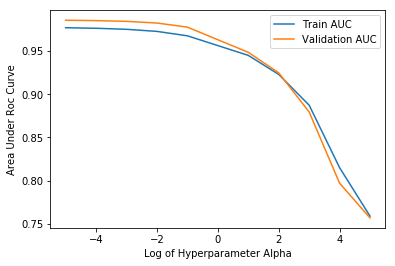

In [61]:
#Alpha V/S AUC score on train and validation data

alpha=[10**-5,10**-4,10**-3,10**-2,10**-1,10,10**2,10**3,10**4,10**5]
auc_train=[]
auc_val=[]
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_bow, Y_train, test_size=0.3)
for a in alpha:
    clf = MultinomialNB(a)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for a in alpha:
    clf=MultinomialNB(a)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

log_alph=[]    
for item in alpha:
    log_alph.append(log10(item))

    
# plot misclassification error vs k 
plt.plot(log_alph,auc_train )
plt.plot(log_alph,auc_val)
plt.xlabel('Log of Hyperparameter Alpha')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()


AUC: 0.938


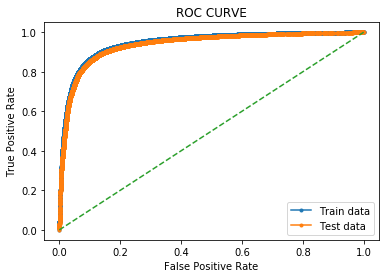

In [63]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#ROC curve on train and test data

clf = MultinomialNB(.01)
clf.fit(Xtrain_bbw,Y_train)
# predict probabilities
probs = clf.predict_proba(Xtest_bbw)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(Xtrain_bbw)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


 TPR=0.265680%

 FPR=0.037780%

 TNR=0.260400%

 FNR=0.036140%


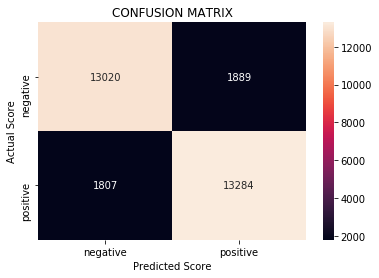

In [70]:
#Confusion Matrix
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
clf= MultinomialNB(.01)
clf.fit(Xtrain_bbw,Y_train)

pred = clf.predict(Xtest_bbw)
con_mat=confusion_matrix(Y_test,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])
tn,fp,fn,tp=con_mat.ravel()
n=50000  #total number of negative or positive points
TPR=tp/n #True Positive Rate
FPR=fp/n #False Positive Rate
TNR=tn/n #True Negative Rate
FNR=fn/n #False Negative Rate
print('\n TPR=%f%%' % TPR)
print('\n FPR=%f%%' % FPR)
print('\n TNR=%f%%' % TNR)
print('\n FNR=%f%%' % FNR)



#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [51]:
#Using k-fold cross validation
cv_scores=[]
alph=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] 

for i in alph:
    clf=MultinomialNB(alpha=i)
    scores = cross_val_score(clf,Xtrain_tf, Y_train, cv=10, scoring='roc_auc')
    cv_scores.append(scores.mean())
MAUC = [ x for x in cv_scores]    
optimal_al = alph[MAUC.index(max(MAUC))]
print('\nThe optimal alpha is %f.' % optimal_al)



The optimal alpha is 1.000000.


In [52]:
#Using GridSearchCV

tuned_parameters = [{'alpha':[10**-5,10**-4,10**-3,10**-2,10**-1,10]}]
model = GridSearchCV(MultinomialNB(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_tf, Y_train)

print(model.best_estimator_)
print(model.score(Xtest_tf, Y_test))

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
0.9564076133842064


In [53]:
#Feature Importance
clf_optimal=MultinomialNB(.1)
clf_optimal.fit(Xtrain_tf,Y_train)

neg_class_prob_sorted = clf_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf_optimal.feature_log_prob_[1, :].argsort()
    

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [54]:
print("\nImportant words in predicting positive class:")
print("\n")
print( np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[-10:]))
    


Important words in predicting positive class:


['one' 'taste' 'product' 'coffee' 'tea' 'like' 'love' 'good' 'great' 'not']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [55]:
print("\nImportant words in predicting negative class:")
print("\n")
print( np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[-10:]))
    


Important words in predicting negative class:


['good' 'no' 'flavor' 'one' 'coffee' 'would' 'taste' 'product' 'like'
 'not']


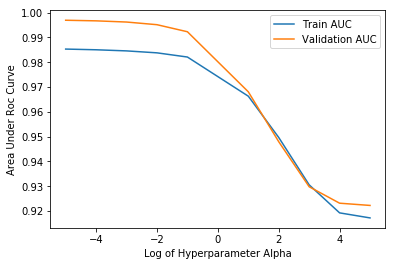

In [65]:
#Alpha V/S AUC score on train and validation data

alpha=[10**-5,10**-4,10**-3,10**-2,10**-1,10,10**2,10**3,10**4,10**5]
auc_train=[]
auc_val=[]
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_tf, Y_train, test_size=0.3)
for a in alpha:
    clf = MultinomialNB(a)
    clf.fit(X_tr,Y_tr)
    pred_train = clf.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    
for a in alpha:
    clf=MultinomialNB(a)
    clf.fit(X_cv,Y_cv)   
    pred_val=clf.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

log_alph=[]    
for item in alpha:
    log_alph.append(log10(item))

    
# plot misclassification error vs k 
plt.plot(log_alph,auc_train )
plt.plot(log_alph,auc_val)
plt.xlabel('Log of Hyperparameter Alpha')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()


AUC: 0.956


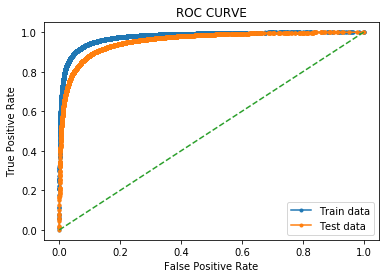

In [67]:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
#ROC curve on train and test data

clf = MultinomialNB(.1)
clf.fit(Xtrain_tf,Y_train)
# predict probabilities
probs = clf.predict_proba(Xtest_tf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=clf.predict_proba(Xtrain_tf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_train, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_test,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


 TPR=0.266980%

 FPR=0.030500%

 TNR=0.267680%

 FNR=0.034840%


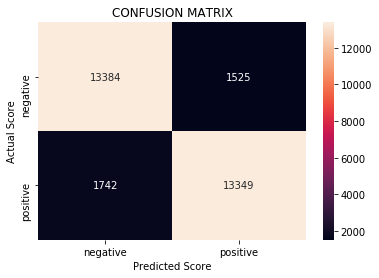

In [69]:
#Confusion Matrix
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
clf= MultinomialNB(.1)
clf.fit(Xtrain_tf,Y_train)

pred = clf.predict(Xtest_tf)
con_mat=confusion_matrix(Y_test,pred)
tn,fp,fn,tp=con_mat.ravel()
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])
n=50000  #total number of negative or positive points
TPR=tp/n #True Positive Rate
FPR=fp/n #False Positive Rate
TNR=tn/n #True Negative Rate
FNR=fn/n #False Negative Rate
print('\n TPR=%f%%' % TPR)
print('\n FPR=%f%%' % FPR)
print('\n TNR=%f%%' % TNR)
print('\n FNR=%f%%' % FNR)


#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

# [6] Conclusions

In [71]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Hyperparameter", "AUC"]

x.add_row(["BOW",.01,0.938])
x.add_row(["TFIDF",0.1,0.956])

print(x)

+------------+----------------+-------+
| Vectorizer | Hyperparameter |  AUC  |
+------------+----------------+-------+
|    BOW     |      0.01      | 0.938 |
|   TFIDF    |      0.1       | 0.956 |
+------------+----------------+-------+
